## Import libraries


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

Import the data into train and test data

In [2]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sample = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')


In [3]:
print(len(train_data))
print(len(test_data))

7613
3263


* Drop the columns id,keyword,location 

In [4]:
y = train_data.target
train_data =train_data.drop(['id','keyword','location','target'],axis =1)

* Remove all stopwords, retweets, links and hashtags
* Tokenize the tweets and store them in an array
* store only stemming words in an array

In [5]:
def process_text(text):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove old style retweet text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    text_tokens = tokenizer.tokenize(text)

    texts_clean = []
    for word in text_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            texts_clean.append(stem_word)


    return texts_clean


* Get the frequency of each word of both disater and non disaster tweets and store them in freqs

In [6]:
def build_freqs(texts, ys):

    yslist = np.squeeze(ys).tolist()

    freqs = {}
    for y, text in zip(yslist, texts):
        for word in process_text(text):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [7]:
freqs = build_freqs(train_data['text'],y)

In [8]:
def extract_features(text, freqs):
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_text(text)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
    
    
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word,1.0), 0)
        
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word,0.0), 0)
        
    assert(x.shape == (1, 3))
    return x

In [9]:
X = np.zeros((len(train_data), 3))
for i in range(len(train_data)):
    X[i, :]= extract_features(train_data.text[i], freqs)


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score


In [11]:
y.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [12]:
len(X)

7613

In [13]:
model = LogisticRegression(penalty= 'l2' ,random_state= 42 ,max_iter=20,solver='liblinear',class_weight= 'balanced')
model.fit(X[:5500],y[:5500])

LogisticRegression(class_weight='balanced', max_iter=20, random_state=42,
                   solver='liblinear')

In [14]:
y_pred = model.predict(X[5500:])

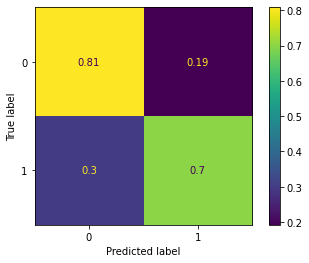

In [15]:
plot_confusion_matrix(model, X[:5500], y[:5500],labels=[0,1],normalize= 'true')

In [16]:
accuracy = accuracy_score(y[5500:],y_pred)
accuracy

0.7960246095598675

In [17]:
main_model = LogisticRegression(penalty= 'l2' ,random_state= 42 ,max_iter=20,solver='liblinear',class_weight= 'balanced')
main_model.fit(X,y)

LogisticRegression(class_weight='balanced', max_iter=20, random_state=42,
                   solver='liblinear')

In [18]:
X_test = np.zeros((len(test_data), 3))
for i in range(len(test_data)):
    X_test[i, :]= extract_features(test_data.text[i], freqs)


In [19]:
y_test_pred = main_model.predict(X_test)

In [20]:
submission = pd.DataFrame({'id':sample['id'],'target': y_test_pred})
submission.to_csv('My_submission.csv',index = False)